Simple autoencoder with PyTorch
-------

## Imports

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np

In [0]:
batch_size = 32

In [0]:

transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=True, num_workers=1)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                          shuffle=False, num_workers=1)


Files already downloaded and verified


In [0]:
def imshow(img):
    plt.imshow(np.transpose((img / 2 + 0.5).numpy(), (1,2,0)))

In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [0]:
plt.rcParams["axes.grid"] = False

horse  ship truck  bird truck  bird   cat


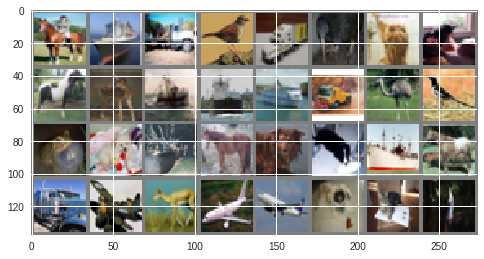

In [0]:
# show some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s'%classes[labels[j]] for j in range(7)))

## Model

In [0]:
class encoder(nn.Module):
  def __init__(self, num_convs, batch_shape, bneck_size, channels):
    super(encoder, self).__init__()
    conv_default = lambda i, o: nn.Sequential(nn.Conv2d(i, o, 3, padding=1),
                               nn.BatchNorm2d(o),
                               nn.ELU(),
                               nn.MaxPool2d(2)
                               )
#     conv1 = conv_default(3, 32)
    #conv layers with 32, 64, etc. channels
    con = [conv_default(channels[i], channels[i + 1]) for i in range(num_convs)]
    self.convs = nn.Sequential()
    for i, c in enumerate(con): self.convs.add_module('conv_'+str(i+1), c)
    num_pixels = (batch_shape[2]*batch_shape[3]) >> (len(con)*2)
    self.bottleneck = nn.Linear(num_pixels * channels[-1], bneck_size)
    
  def forward(self, x):
    out = self.convs(x)
    return self.bottleneck(out.view(batch_size, int(out.numel()/batch_size)))

In [161]:
encoder_depth = 2
bn_size = 128
channels = [3,32,64]

model = encoder(encoder_depth, images.shape, bn_size, channels).cuda()
model

encoder(
  (convs): Sequential(
    (conv_1): Sequential(
      (0): Conv2d (3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
      (2): ELU(alpha=1.0)
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
    (conv_2): Sequential(
      (0): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): ELU(alpha=1.0)
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
  )
  (bottleneck): Linear(in_features=4096, out_features=128)
)

In [0]:
# se = nn.Sequential(nn.Conv2d(3,32,3,padding=1),
#                   nn.Conv2d(32,3,3,stride=2,padding=1),
#                   nn.Conv2d(3,3,3,stride=2,padding=1))
# ten = torch.Tensor(torch.randn(1,3,10,10))

In [0]:
# se[1](se[0](Variable(ten))).shape

In [164]:
test_batch = Variable(torch.randn(32,3,32,32)).cuda()
out = model(test_batch)
out.shape

torch.Size([32, 128])

In [0]:
class decoder(nn.Module):
  def __init__(self, num_deconv, batch_shape, bn_size, channels):
    super(decoder, self).__init__()
  
    self.fmap_shape = (channels[0], batch_shape[2] >> num_deconv, batch_shape[3] >> num_deconv)
#     print(self.fmap_shape)
    fmap_size = self.fmap_shape[1] * self.fmap_shape[2]
    self.bn = nn.Sequential(nn.Linear(bn_size, fmap_size * channels[0]),
                            nn.BatchNorm1d(fmap_size * channels[0]),
                            nn.ELU())                            
    
    
    deconv_default = lambda i, o: nn.Sequential(#nn.ZeroPad2d((1,0,1,0)),
                                         nn.ConvTranspose2d(i, o, 3, stride=2, padding=1, output_padding=1),
                                         nn.BatchNorm2d(o),
                                         nn.ELU(),
#                                          nn.UpsamplingBilinear2d()
                               )
    decon = [deconv_default(channels[i], channels[i+1]) for i in range(num_deconv)]
    self.deconvs = nn.Sequential()
    for i,d in enumerate(decon): self.deconvs.add_module('deconv_'+str(i+1), d)
    self.final = nn.Sequential(nn.Conv2d(channels[-2], channels[-1], 3, padding=1),
                              nn.BatchNorm2d(channels[-1]),
                              nn.Sigmoid())
  def forward(self,x):
    out = self.bn(x)
    sh = (batch_size,) + self.fmap_shape
    out = out.view(sh)
#     out = self.deconvs[0][0](out)
    out = self.deconvs(out)
    return self.final(out)
    return out

In [168]:
channels_decode = [64,32,32,3]
decod = decoder(2, images.shape, bn_size, channels_decode).cuda()
decod

decoder(
  (bn): Sequential(
    (0): Linear(in_features=128, out_features=4096)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True)
    (2): ELU(alpha=1.0)
  )
  (deconvs): Sequential(
    (deconv_1): Sequential(
      (0): ConvTranspose2d (64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
      (2): ELU(alpha=1.0)
    )
    (deconv_2): Sequential(
      (0): ConvTranspose2d (32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
      (2): ELU(alpha=1.0)
    )
  )
  (final): Sequential(
    (0): Conv2d (32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
    (2): Sigmoid()
  )
)

In [169]:
decod(out).shape

torch.Size([32, 3, 32, 32])

In [0]:
# v = Variable(torch.randn(1,3,5,5))
# print(v.shape)
# v= nn.Conv2d(3,3,3,padding=1)(v)
# print(v.shape)
# v= nn.ConvTranspose2d(3,1,3,stride=2,padding=0,output_padding=1)(v)
# print(v.shape)
# v = nn.ZeroPad2d((1,0,1,0))(v)
# v.shape


In [170]:
class autoencoder(nn.Module):
  def __init__(self, depth, batch_shape, bneck_size, channels_enc, channels_dec):
    super(autoencoder, self).__init__()
    self.seq = nn.Sequential()
    self.seq.add_module('encoder', encoder(depth, batch_shape, bneck_size, channels_enc))
    self.seq.add_module('decoder', decoder(depth, batch_shape, bneck_size, channels_dec))
  def forward(self, x): return self.seq(x)
    
autoenc = autoencoder(encoder_depth, images.shape, bn_size, channels, channels_decode).cuda()
autoenc

autoencoder(
  (seq): Sequential(
    (encoder): encoder(
      (convs): Sequential(
        (conv_1): Sequential(
          (0): Conv2d (3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
          (2): ELU(alpha=1.0)
          (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
        )
        (conv_2): Sequential(
          (0): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
          (2): ELU(alpha=1.0)
          (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
        )
      )
      (bottleneck): Linear(in_features=4096, out_features=128)
    )
    (decoder): decoder(
      (bn): Sequential(
        (0): Linear(in_features=128, out_features=4096)
        (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True)
        (2): ELU(alpha=1.0)
      )
      (deconvs): Sequential(
     

In [171]:
v = Variable(torch.randn(32,3,32,32)).cuda()
autoenc(v).shape

torch.Size([32, 3, 32, 32])

## Training

In [0]:
lr = 1e-3

In [0]:
optim = torch.optim.Adam(autoenc.parameters(), lr=lr)#weight_decay=1e-7)
criterion = nn.MSELoss().cuda()

In [184]:
for epoch in range(5):
  lrate = lr * (0.1**epoch)
  for param_group in optim.param_groups:
    param_group['lr'] = lrate

  for i, data in enumerate(trainloader, 0):
    batch = data[0]
    batch = Variable(batch).cuda()
    if (not batch.shape[0] == 32):
      continue
      
    
    optim.zero_grad()
    outs = autoenc(batch)
    loss = criterion(outs, batch)
    loss.backward()
    optim.step()
    if i % 500 == 0:
      print(f'epoch: {epoch}\ti: {i}\t loss:{loss.data[0]}')

epoch: 0	i: 0	 loss:0.20068883895874023
epoch: 0	i: 500	 loss:0.1259319931268692
epoch: 0	i: 1000	 loss:0.2162904292345047
epoch: 0	i: 1500	 loss:0.15058556199073792
epoch: 1	i: 0	 loss:0.17194394767284393
epoch: 1	i: 500	 loss:0.1739182025194168
epoch: 1	i: 1000	 loss:0.1636984944343567
epoch: 1	i: 1500	 loss:0.19404356181621552
epoch: 2	i: 0	 loss:0.16006074845790863
epoch: 2	i: 500	 loss:0.139299675822258
epoch: 2	i: 1000	 loss:0.2007630467414856
epoch: 2	i: 1500	 loss:0.1479201763868332
epoch: 3	i: 0	 loss:0.21201859414577484
epoch: 3	i: 500	 loss:0.1523190587759018
epoch: 3	i: 1000	 loss:0.1729552298784256
epoch: 3	i: 1500	 loss:0.17654402554035187
epoch: 4	i: 0	 loss:0.18594352900981903
epoch: 4	i: 500	 loss:0.1512107104063034
epoch: 4	i: 1000	 loss:0.18376202881336212
epoch: 4	i: 1500	 loss:0.12220700830221176


In [0]:
# imshow(torchvision.utils.make_grid(outs.data.cpu()))

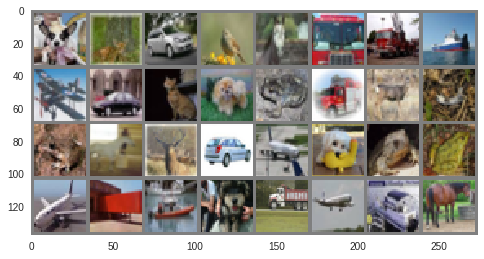

In [185]:
imshow(torchvision.utils.make_grid(images))

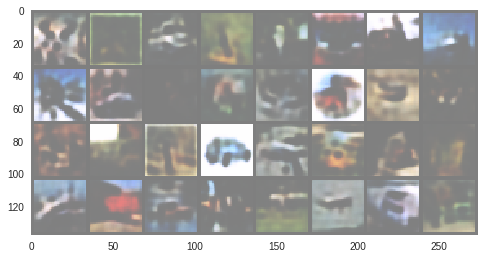

In [186]:
imv = Variable(images).cuda()
outs = autoenc(imv)
imshow(torchvision.utils.make_grid(outs.data.cpu()))

## Testing

In [187]:
# for epoch in range(2):
  lastloss = 1e5
  for i, data in enumerate(testloader, 0):
    batch = data[0]
    batch = Variable(batch).cuda()
    if (not batch.shape[0] == 32):
      continue
    outs = autoenc(batch)
    loss = criterion(outs, batch)
    optim.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}\ti: {i}\t loss:{loss.data[0]}')

epoch: 4	i: 0	 loss:0.1691318154335022
epoch: 4	i: 200	 loss:0.13637350499629974


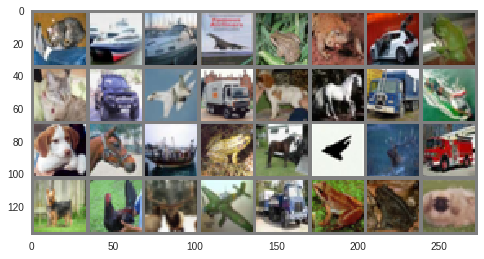

In [188]:
im_test = iter(testloader).next()[0]
grid = torchvision.utils.make_grid
imshow(grid(im_test))

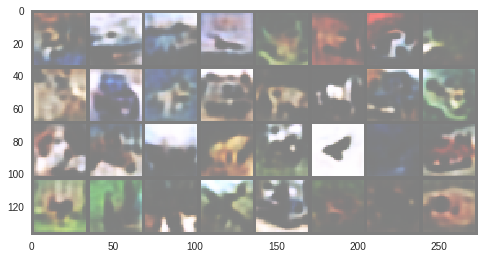

In [189]:
itv = Variable(im_test).cuda()
imshow(grid(autoenc(itv).data.cpu()))